In [1]:
import numpy as np
import pandas as pd
import ast
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")
df = movies.merge(credits, on="title")

# dates
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year.fillna(0).astype(int)
df["release_month"] = df["release_date"].dt.month.fillna(0).astype(int)

# numeric clean
nums = ["budget","revenue","runtime","popularity","vote_count","vote_average"]
for col in nums:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["runtime"].fillna(df["runtime"].median(), inplace=True)
df["vote_average"].fillna(df["vote_average"].mean(), inplace=True)
df["log_vote_count"] = np.log1p(df["vote_count"])

# Actor and Director Scores
actor_scores = defaultdict(list)
director_scores = defaultdict(list)

for _, row in df[["cast","crew","vote_average"]].iterrows():
    rating = row["vote_average"]

    # Actors
    try:
        for c in ast.literal_eval(row["cast"]):
            if c.get("id"):
                actor_scores[c["id"]].append(rating)
    except:
        pass

    # Directors
    try:
        for p in ast.literal_eval(row["crew"]):
            if p.get("job") == "Director" and p.get("id"):
                director_scores[p["id"]].append(rating)
    except:
        pass

# Compute averages
global_mean = df["vote_average"].mean()
actor_avg = {k: np.mean(v) for k,v in actor_scores.items()}
director_avg = {k: np.mean(v) for k,v in director_scores.items()}

# Actor + Director Features
def extract_simple_features(row):
    # Top 3 actors
    try:
        cast = sorted(ast.literal_eval(row["cast"]), key=lambda x: x.get("order", 999))[:3]
    except:
        cast = []

    cast_vals = [actor_avg.get(c.get("id"), global_mean) for c in cast]
    top_cast_score = np.mean(cast_vals) if cast_vals else global_mean
    top_cast_count = len(cast_vals)

    # Directors
    try:
        directors = [d.get("id") for d in ast.literal_eval(row["crew"]) if d.get("job")=="Director"]
    except:
        directors = []

    director_score = np.mean([director_avg.get(d, global_mean) for d in directors]) if directors else global_mean

    return pd.Series([top_cast_score, top_cast_count, director_score])

df[["top_cast_score","top_cast_count","director_score"]] = df.apply(extract_simple_features, axis=1)

# Final feature set
features = [
    "top_cast_score",
    "top_cast_count",
    "director_score",
    "log_vote_count",
]

X = df[features].fillna(0)
y = df["vote_average"]

In [2]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SVM with RBF Kernel
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import time

print("\n===== TRAINING SVM (RBF) =====")

start = time.time()

best_model = Pipeline([
    ("scale", StandardScaler()),
    ("svr", SVR(
        kernel="rbf",
        C=10,
        epsilon=0.1,
        gamma="scale",
        max_iter=5000
    ))
])

best_model.fit(X_train, y_train)

# Predictions with clamping 0–10
y_train_pred = np.clip(best_model.predict(X_train), 0, 10)
y_test_pred = np.clip(best_model.predict(X_test), 0, 10)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

end = time.time()

print(f"Train MSE: {train_mse:.4f} | Train R²: {train_r2:.4f}")
print(f"Test  MSE: {test_mse:.4f} | Test  R²: {test_r2:.4f}")
print(f"Total training time: {end - start:.2f} seconds")

# Store scaler for recommend_movies()
scaler = best_model.named_steps["scale"]
model = best_model


===== TRAINING SVM (RBF) =====
Train MSE: 0.2245 | Train R²: 0.8460
Test  MSE: 0.2072 | Test  R²: 0.8402
Total training time: 1.44 seconds


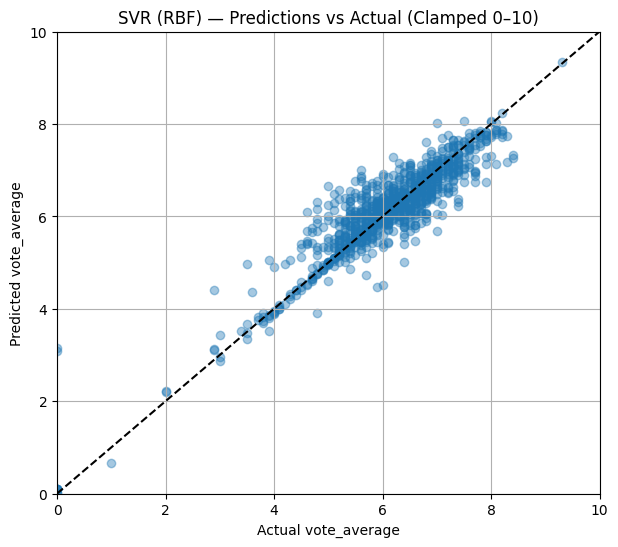

In [3]:
# Prediction Plot
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([0, 10], [0, 10], "k--")
plt.xlabel("Actual vote_average")
plt.ylabel("Predicted vote_average")
plt.title("SVR (RBF) — Predictions vs Actual (Clamped 0–10)")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)
plt.show()

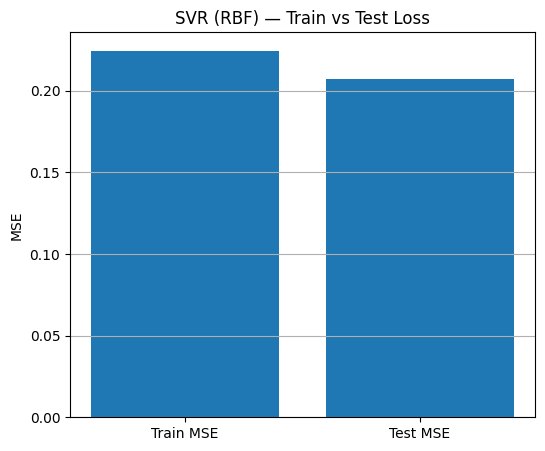

In [4]:
# Loss Plot
plt.figure(figsize=(6,5))
plt.bar(["Train MSE", "Test MSE"], [train_mse, test_mse])
plt.title("SVR (RBF) — Train vs Test Loss")
plt.ylabel("MSE")
plt.grid(axis='y')
plt.show()

In [5]:
def filter_by_actor_director(df, actor_name=None, director_name=None):
    filtered = df.copy()

    # Filter by actor
    if actor_name is not None:
        def has_actor(cast_str):
            try:
                cast_list = ast.literal_eval(cast_str)
                return any(member.get('name') == actor_name for member in cast_list)
            except:
                return False
        filtered = filtered[filtered['cast'].apply(has_actor)]

    # Filter by director
    if director_name is not None:
        def has_director(crew_str):
            try:
                crew_list = ast.literal_eval(crew_str)
                return any(member.get('job') == 'Director' and member.get('name') == director_name
                           for member in crew_list)
            except:
                return False
        filtered = filtered[filtered['crew'].apply(has_director)]

    return filtered

def find_actor_id(df, name):
    """Return TMDB actor ID given actor name."""
    name = name.lower()
    for cast_json in df["cast"]:
        try:
            for c in ast.literal_eval(cast_json):
                if c.get("name", "").lower() == name:
                    return c.get("id")
        except:
            pass
    return None


def find_director_id(df, name):
    """Return TMDB director ID given director name."""
    name = name.lower()
    for crew_json in df["crew"]:
        try:
            for m in ast.literal_eval(crew_json):
                if m.get("job") == "Director" and m.get("name", "").lower() == name:
                    return m.get("id")
        except:
            pass
    return None

def recommend_movies(df, model, scaler, user_pref, top_n=10):
    cand = df.copy()

    # Actor Filtering
    if "actor_name" in user_pref:
        actor_id = find_actor_id(df, user_pref["actor_name"])
        if actor_id is None:
            print(f"Actor '{user_pref['actor_name']}' not found.")
            return pd.DataFrame()

        def actor_in_movie(cast_json):
            try:
                cast = ast.literal_eval(cast_json)
                return any(c.get("id") == actor_id for c in cast)
            except:
                return False

        cand = cand[cand["cast"].apply(actor_in_movie)]

    # Dircetor Filtering
    if "director_name" in user_pref:
        director_id = find_director_id(df, user_pref["director_name"])
        if director_id is None:
            print(f"Director '{user_pref['director_name']}' not found.")
            return pd.DataFrame()

        def director_in_movie(crew_json):
            try:
                crew = ast.literal_eval(crew_json)
                return any(
                    m.get("job") == "Director" and m.get("id") == director_id
                    for m in crew
                )
            except:
                return False

        cand = cand[cand["crew"].apply(director_in_movie)]

    # Genre Filtering
    if "genre" in user_pref:
        genre = user_pref["genre"].lower()

        def has_genre(g_json):
            try:
                genres = ast.literal_eval(g_json)
                return any(g.get("name","").lower() == genre for g in genres)
            except:
                return False

        cand = cand[cand["genres"].apply(has_genre)]

    # Numeric Filters
    if "min_popularity" in user_pref:
        cand = cand[cand["popularity"].fillna(0) >= user_pref["min_popularity"]]

    if "min_vote_count" in user_pref:
        cand = cand[cand["vote_count"].fillna(0) >= user_pref["min_vote_count"]]

    if cand.shape[0] == 0:
        print("No movies matched the filters.")
        return pd.DataFrame()

    # Predict Ratings
    feature_cols = ["top_cast_score", "top_cast_count", "director_score", "log_vote_count"]
    X = cand[feature_cols].fillna(0)
    X_scaled = scaler.transform(X)

    cand["predicted_rating"] = np.clip(model.predict(X_scaled), 0, 10)

    cand = cand.sort_values(
        by=["predicted_rating", "popularity"],
        ascending=[False, False]
    )

    return cand[["title", "predicted_rating", "vote_count", "popularity"]].head(top_n)

In [6]:
user_pref = {
    "actor_name": "Scarlett Johansson",
    "min_vote_count": 200
}
recs = recommend_movies(df, model, scaler, user_pref, top_n=10)
print(recs)

                                    title  predicted_rating  vote_count  \
1197                         The Prestige          4.130659        4391   
16                           The Avengers          4.095403       11776   
7                 Avengers: Age of Ultron          4.072752        6767   
1154                                 Lucy          4.058881        5878   
1639                  Eight Legged Freaks          4.056713         295   
1999                                  Her          4.055865        4097   
26             Captain America: Civil War          3.986402        7241   
85    Captain America: The Winter Soldier          3.971249        5764   
79                             Iron Man 2          3.966284        6849   
78                        The Jungle Book          3.933989        2892   

      popularity  
1197   74.440708  
16    144.448633  
7     134.279229  
1154  115.241998  
1639   17.834976  
1999   53.682367  
26    198.372395  
85     72.225265  
79 